## Generate Training Data for DeepCormack: PCA + DMD

#### Required:
- A DFT calculated 3D electron momentum density (copper in our case)

- Output:

In [ ]:
# Create conda environment for MCM first. In the terminal, run:
# conda env create -f environment.yml
from MCM_functions_new import *

In [43]:
"""Defining Modified Cormack Method Parameters"""

N = 513                                                                     # image size (N x N pixels) of copper projections                                    
raw_proj_dir = "Data_Generation_Required/Cu_20Projections(513)"             # directory containing ideal copper projections

pang = np.linspace(0, 45, 20)                                               # projection angles for the 20 projections for the DFT copper data        
ncoeffs = [150, 120, 100, 90, 80, 50]                                       # number of Chebyshev coefficients for each projection angle      
ncoeffs.extend([30]* (20-len(ncoeffs)))

order = 4                                                                   # copper's FCC structure means it has 4-fold symmetry (order = 4)                                  
nphi = 180                                                                  # angle increments for delta in polar unit circle are given by 90/nphi; 'm_max = nphi' when computing Chebyshev coefficients      
# calib = 0.09808                                                             # Experimental data calibration factor (pixels per mm) for copper data — NOT USED                           
xsize = (N + 1) // 2                                                        # Centre of the image in pixels
rhocut = 1                                                                  # 1 = don't cut off, 0 = cut off at flvl 
flvl = 100                                                                  # Choose Fermi level so the cutoff starts at your desired px (e.g., 256) (max value is N/2 = 256 for N=513)
kt = 6.0                                                                    # Slope; increase for smoother, decrease for sharper
rhofn = [rhocut, flvl, kt]
rhofn_PCA = [0, 200, 6.0]

# Generating Experimental Data.
num_simulations = 1                                                         # Number of simulated 3D TPMD datasets to generate                               
count_ttl = 200_000_000                                                     # What should the simulated total counts be? ≈200,000,000 corresponds to 3 months of measurements!

base_dir = "Data_Generation_Required/TPMD_Data"
rho_real_dir = os.path.join(base_dir, "Rho_Measurement")
os.makedirs(rho_real_dir, exist_ok=True)

rho_ideal_dir = os.path.join(base_dir, "Rho_GroundTruth")
os.makedirs(rho_ideal_dir, exist_ok=True)


#### Copper 3D TPMD – PCA sampling of Chebyshev coefficients

In [7]:
""" --- Copper 3D TPMD ---

Calculate a_n^m and rho_n for the ideal DFT copper projections. PCA per channel 'n' will be used on copper a_n^m 
coefficients all 256 slices combined. Randomly sampling from each of the 'n' the latent spaces will generate new, 
realistic a_n^m coefficients, giving us a consistent way to create new, realistic rho_n for TPMD central slices.

    Parameters
    ----------
    raw_projs : shape (N, N, nproj) = (513, 513, 20)
    anm_Cu : shape (xsize, nphi, nproj) = (256, 180, 20)
    rhoreturn_ideal_Cu : shape (xsize, nphi, xsize) = (256, 20, 256). 
                            The final index denotes the rho_n slices.
"""

# Fetching the ideal copper projections
file_names = [f"I_TPMD2D.OUT_PROJ_{i+1}" for i in range(20)]
raw_projs = load_projections(raw_proj_dir, file_names, N)                   # shape (N, N, 20)
rhoreturn_ideal_Cu, anm_Cu = getrho(raw_projs, order, pang, nphi, 20 * [120], rhofn)


In [24]:
# Standardize the anm matrix so that for each j and i, anm[j][:, i] has mean 0 and std 1.
anm_pca, means_orig, stds_orig = standardize_anm(anm_Cu)                    # means_orig, stds_orig store the original means and stds for each (j, i) to unstandardize later
how_much_var = 58                                                           # e.g., dim=24 gives 95% of variance, dim=34 gives 99%, and dim=58 gives 99.97%.

n_components = how_much_var                                                 # PCA latent space dimensions
latent_spaces = []                                                          # store latent coordinates (256 × n_components)
pca_models = []                                                             # store PCA models
latent_means = []
latent_covs = []

for k in range(anm_pca.shape[2]):  # iterate over 20 functions
    X = anm_pca[:, :, k]  # shape (256, 180)

    # Center the data (important!)
    X_centered = X - X.mean(axis=0, keepdims=True)

    # Fit PCA across slices
    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(X_centered)                                       # shape (256, n_components)

    latent_spaces.append(Z)
    pca_models.append(pca)
    latent_means.append(Z.mean(axis=0))
    latent_covs.append(np.cov(Z, rowvar=False))

In [ ]:
# mean_Z = latent_spaces[k].mean(axis=0)
# cov_Z = np.cov(latent_spaces[k], rowvar=False)

# # Sample new latent coordinates
# Z_new = np.random.multivariate_normal(mean_Z, cov_Z, size=20)  # e.g., 20 new slices

# # Reconstruct new coefficients
# X_new = pca_models[k].inverse_transform(Z_new)

In [15]:
# Sampling new synthetic a_n^m coefficients for all 'n = 20' a_n^m channels/functions
anm_pca_synthetic = np.zeros_like(anm_pca)

for k in range(anm_pca.shape[2]):  # for each function
    mean_Z = latent_means[k]
    cov_Z = latent_covs[k]
    pca = pca_models[k]

    # Sample new latent coordinates for 256 slices
    Z_new = np.random.multivariate_normal(mean_Z, cov_Z, size=anm_pca.shape[0])  # (256, n_components)

    # Optional: smooth slightly along slices for realistic variation
    # from scipy.ndimage import gaussian_filter1d
    # Z_new_smooth = gaussian_filter1d(Z_new, sigma=1, axis=0)

    # Reconstruct new coefficients
    X_new = pca.inverse_transform(Z_new)
    
    # Add back the original mean (since PCA used centered data)
    X_new += anm_pca[:, :, k].mean(axis=0, keepdims=True)

    anm_pca_synthetic[:, :, k] = X_new

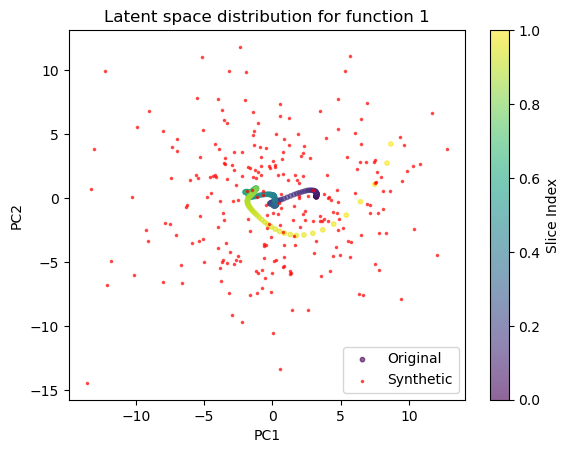

(256, 58)


In [42]:
visualize_function = 0
Z_orig = pca_models[visualize_function].transform(anm_pca[:, :, visualize_function] - anm_pca[:, :, visualize_function].mean(axis=0))
zoot = 0
plt.scatter(Z_orig[:, zoot], Z_orig[:, zoot+1], s=10, label='Original', alpha=0.6, c=np.arange(anm_pca.shape[0]), cmap='viridis')
plt.scatter(Z_new[:, zoot], Z_new[:, 1], s=10, label='Synthetic', alpha=0.6, marker='.',color='red')
plt.legend()
plt.colorbar(label='Slice Index', orientation='vertical', location='right')
plt.title(f"Latent space distribution for function {visualize_function+1}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
print(Z_orig.shape)

In [46]:
anm_synth, _, _ = standardize_anm(anm_pca_synthetic)
anm_synth = unstandardize_anm(anm_synth, means_orig, stds_orig)

rhoreturn_synth = getrho_anm_synth(raw_projs, order, pang, nphi, ncoeffs, rhofn_PCA, anm_synth)
rhoreturn_synth_norm, max_vals_synth = normalize_rhoreturn_ideal_Cu(rhoreturn_synth)

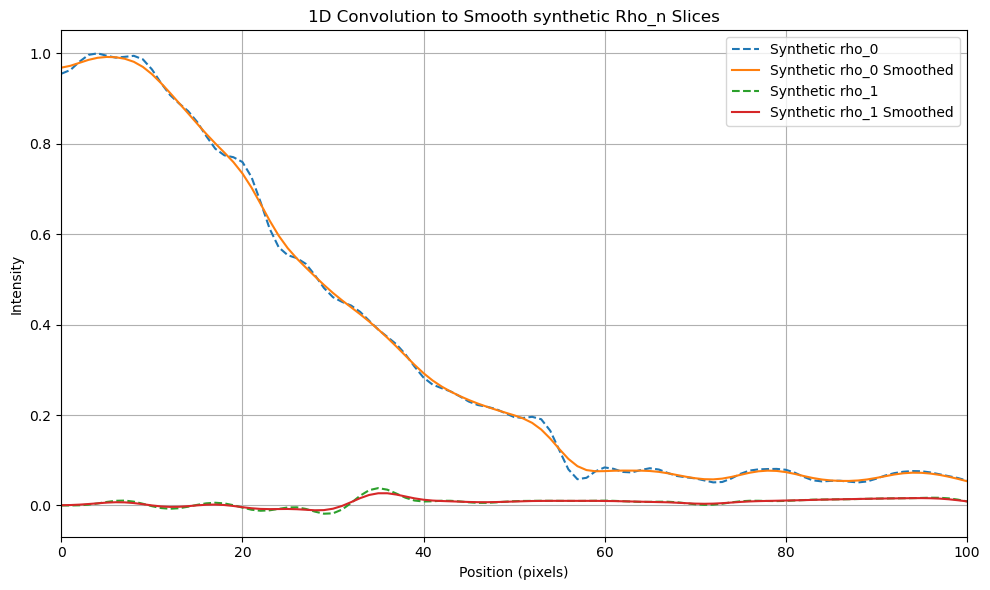

In [57]:
sigma = 2  # Adjust smoothing as needed
slice_idx = 0

plt.figure(figsize=(10, 6))
for i in range(0, 2):  # i from 0 to 20 inclusive
    smoothed = gaussian_filter1d(rhoreturn_synth_norm[:, i, slice_idx], sigma=sigma)
    plt.plot(rhoreturn_synth_norm[:, i, slice_idx], linestyle='--', label=f"Synthetic rho_{i}")
    plt.plot(smoothed,label=f"Synthetic rho_{i} Smoothed")

plt.title('1D Convolution to Smooth synthetic Rho_n Slices')
plt.xlabel('Position (pixels)')
plt.ylabel('Intensity')
plt.legend()
plt.xlim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()